In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer
import torch
from torch.autograd import Variable
import h5py

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [3, 1]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

## Settings

In [2]:
nbatch = 6000
N = 3
M = 2
nM = M - 1
qM = int(np.log2(M))
num_dim = 1
num_qubits = int(N**2 * np.log2(M))
num_discrete_values = 2**num_qubits

file_name = "QG_train_normalized_N3_M2_bilinear_xl"

reg = 0.000001

## Data

In [3]:
f = h5py.File(file_name,"r")

In [4]:
x_train = f.get('X')
y_train = f.get('y')

(-0.5, 2.5, 2.5, -0.5)

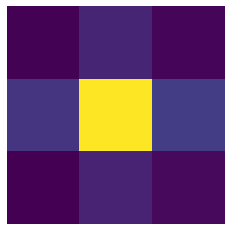

In [5]:
plt.imshow(np.mean(x_train[y_train[:]==1],axis=0),norm=matplotlib.colors.LogNorm())
plt.axis('off')

(-0.5, 2.5, 2.5, -0.5)

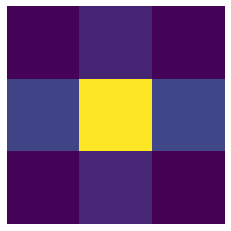

In [6]:
plt.imshow(np.mean(x_train[y_train[:]==0],axis=0),norm=matplotlib.colors.LogNorm())
plt.axis('off')

(-0.5, 2.5, 2.5, -0.5)

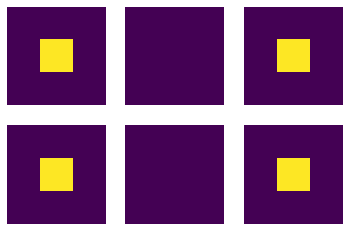

In [7]:
fig, ax = plt.subplots(2, 3)
nums = np.random.randint(0,6,size=(6,))
ax[0,0].imshow(x_train[nums[0]])
ax[0,0].axis('off')
ax[0,1].imshow(x_train[nums[1]])
ax[0,1].axis('off')
ax[0,2].imshow(x_train[nums[2]])
ax[0,2].axis('off')
ax[1,0].imshow(x_train[nums[3]])
ax[1,0].axis('off')
ax[1,1].imshow(x_train[nums[4]])
ax[1,1].axis('off')
ax[1,2].imshow(x_train[nums[5]])
ax[1,2].axis('off')

In [8]:
data = x_train[y_train[:]==1]

In [9]:
f.close()

In [10]:
data.shape

(49962, 3, 3)

In [11]:
prob_distr = data.reshape(-1,9)

In [12]:
mean_data = np.mean(data,axis=0)

## Utillity functions

In [13]:
def int_to_bin_list(num,bits):
    return [(num>>k)&1 for k in range(0,bits)][::-1]

In [14]:
def convert_dim_to_integer(arr,dim):
    # Calculate the number of possible values 
    num_values = 2 ** arr.shape[dim]
    arr = torch.flip(arr,(1,))
    # Sum along the last dimension to convert it to integers
    integer_array = np.sum(arr * (2 ** np.arange(arr.shape[dim])), axis=-1)

    return torch.tensor(integer_array)

In [15]:
def normalize_image(img):
    return img / nM

In [16]:
def basis_array_to_img(basis_array):
    basis_array = basis_array.reshape(N,N,qM)
    return normalize_image(convert_dim_to_integer(basis_array,2))

In [17]:
def batch_basis_array_to_img(batch_basis_array):
    batch_basis_array = batch_basis_array.reshape(batch_basis_array.shape[0],N,N,qM)
    return normalize_image(convert_dim_to_integer(batch_basis_array,3))

In [18]:
def tensor_to_int(tensor):
    tensor = tensor.long()
    
    # Calculate the number of columns in the tensor
    num_columns = tensor.size(1)
    
    # Create a weight tensor for binary to integer conversion
    weights = 2 ** torch.arange(num_columns - 1, -1, -1)
    
    # Calculate the integer values for each row
    int_values = torch.sum(tensor * weights, dim=1)
    
    return int_values

In [19]:
from IPython.display import clear_output

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

def plot_training_progress(n, samples_tuple,mean_gen_image):
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
    fig.tight_layout(pad=10.0)

    # Generator Loss
    ax3.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax3.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax3.legend(loc="best", fontsize=16)
    ax3.set_xlabel("epoch", fontsize=16)
    ax3.set_ylabel("Loss", fontsize=16)
    #ax3.grid()

    # Relative Entropy
    ax2.plot(entropies)
    ax2.set_xlabel("epoch", fontsize=18)
    ax2.set_ylabel("KL divergence", fontsize=18)
    ax2.set_yscale("log")
    #ax2.grid()
    
    #paramsg = generator.weights
    #generated_probabilities = circuit(1,paramsg).detach()
    im = ax1.imshow(mean_gen_image, norm=matplotlib.colors.LogNorm())
    plt.colorbar(im,ax=ax1)
    #ax3.grid()
    #plt.savefig(f"imgs/plt-{n}.png")
    
    im2 = ax4.imshow(mean_data, norm=matplotlib.colors.LogNorm())
    plt.colorbar(im2,ax=ax4)
    
    ax5.plot(mses)
    ax5.set_xlabel("epoch", fontsize=18)
    ax5.set_ylabel("MSE", fontsize=18)
        

    plt.show()

In [20]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

# Model

## Generator circuits

In [21]:
dev = qml.device("default.qubit.torch", wires=num_qubits)

@qml.qnode(dev, interface="torch", diff_method="backprop", cachesize=1000000)
def circuit(inputs, weights):
    for wire in range(num_qubits): qml.Hadamard(wires=wire)
    qml.StronglyEntanglingLayers(weights=weights, wires=list(range(num_qubits)))
    return qml.probs()

In [22]:
dev_sample = qml.device("default.qubit", wires=num_qubits, shots=nbatch)

@qml.qnode(dev_sample, interface="torch")
def circuit_sample(inputs, weights):
    for wire in range(num_qubits): qml.Hadamard(wires=wire)
    qml.StronglyEntanglingLayers(weights=weights, wires=list(range(num_qubits)))
    return qml.sample()

## Hybrid model building

In [23]:
n_layers = 30
weight_shapes = {"weights": (n_layers, num_qubits,3)}

In [24]:
qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

In [25]:
from torch import nn

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 50)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear1 = nn.Linear(50, 20)
        self.linear2 = nn.Linear(20, 10)
        self.linear3 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.flatten(input)
        x = self.linear_input(x)
        x = self.leaky_relu(x)
        x = self.linear1(x)
        x = self.leaky_relu(x)
        x = self.linear2(x)
        x = self.leaky_relu(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x
    
class Generator(nn.Module):
    def __init__(self, input_size):
        super(Generator, self).__init__()

        self.linear_input = nn.Linear(input_size, 50)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear1 = nn.Linear(50, 20)
        self.linear2 = nn.Linear(20, 10)
        self.linear3 = nn.Linear(10, 9)
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

    def forward(self, z):
        x = self.flatten(z)
        x = self.linear_input(x)
        x = self.leaky_relu(x)
        x = self.linear1(x)
        x = self.leaky_relu(x)
        x = self.linear2(x)
        x = self.leaky_relu(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        x = torch.reshape(x, (z.shape[0],3,3))
        return x

In [26]:
generator = Generator(5)
discriminator = Discriminator(N**2)

# Training

In [27]:
from torch.optim import Adam

lr = 0.0001  # learning rate
#b1 = 0.7  # first momentum parameter
b1 = 0.6  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0, amsgrad=True)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0, amsgrad=True
)

decayRate = 0.9997
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=decayRate)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=decayRate)

In [28]:
def adversarial_loss(inputs, target, w):
    bce_loss = target * torch.log(inputs) + (1 - target) * torch.log(1 - inputs)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

In [29]:
adversarial_loss_t = torch.nn.BCELoss()

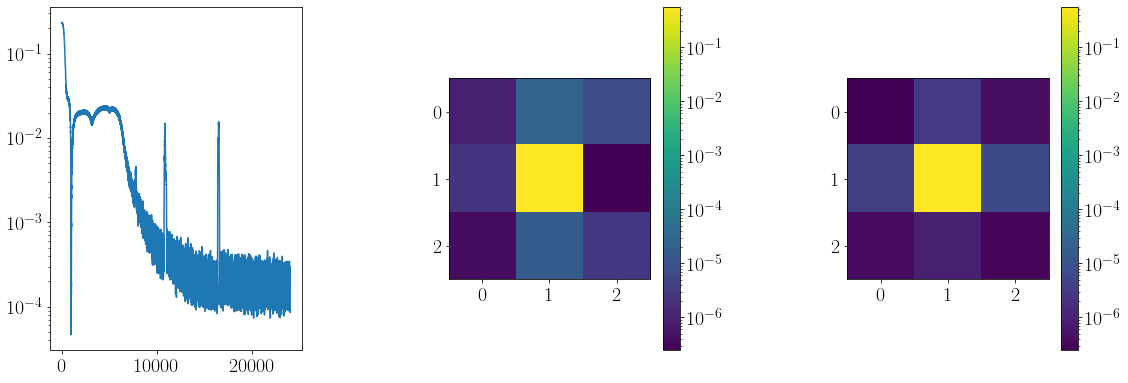

Fit in 63253.79 sec


In [30]:
import time
from scipy.stats import multivariate_normal, entropy

#torch.nn.init.uniform_(list(generator.parameters())[0], a=-np.pi, b=np.pi)
torch.nn.init.uniform_(list(generator.parameters())[0], a=-0.1, b=0.1)

n_epochs = 3000

data = torch.tensor(data, requires_grad=False)

generator_loss_values = []
discriminator_loss_values = []
entropies = []
mses = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(nbatch, dtype=torch.float)
    fake = torch.zeros(nbatch, dtype=torch.float)
    
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=nbatch)):
 

        real_imgs = Variable(Xbatch.type(torch.FloatTensor))

        generator_optimizer.zero_grad()
        
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (Xbatch.shape[0], 5))))
        
        gen_imgs = generator(z)
        
        print(torch.mean(gen_imgs,axis=0))
        
        g_loss = adversarial_loss_t(discriminator(gen_imgs).reshape((-1,1)), valid.reshape((-1,1)))
        
        g_loss.backward()
        generator_optimizer.step()
 
        ####################

        discriminator_optimizer.zero_grad()
        
        real_loss = adversarial_loss_t(discriminator(real_imgs).reshape((-1,1)), valid.reshape((-1,1)))
        fake_loss = adversarial_loss_t(discriminator(gen_imgs.detach()).reshape((-1,1)), fake.reshape((-1,1)))
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        discriminator_optimizer.step()
        
        ####################
        
        mean_gen = torch.mean(gen_imgs, axis=0)
        mean_real = torch.mean(real_imgs, axis=0)
        
        mse_val = torch.mean((mean_gen-mean_real)**2).detach()
        mses.append(mse_val)
        
        clear_output(wait=True)
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 8))
        fig.tight_layout(pad=10.0)
        
        ax1.plot(mses)
        ax1.set_yscale("log")
        
        im = ax2.imshow(mean_gen.detach(), norm=matplotlib.colors.LogNorm())
        plt.colorbar(im,ax=ax2)
        
        m = ax3.imshow(mean_real.detach(), norm=matplotlib.colors.LogNorm())
        plt.colorbar(im,ax=ax3)
        
        plt.show()
        
        #my_lr_scheduler.step()

        #plot_training_progress(epoch, (samples,),mean_gen_image)
        
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

In [31]:
plot_training_progress(epoch, (samples,),mean_gen_image)

NameError: name 'samples' is not defined

In [ ]:
torch.sum(mean_gen_image)

In [ ]:
basis_array_to_img(circuit_sample(1, list(generator.parameters())[0].detach())[0])

In [ ]:
batch_basis_array_to_img(torch.tensor([int_to_bin_list(x,num_qubits) for x in range(2**num_qubits)])).shape

In [ ]:
circuit(1, list(generator.parameters())[0].detach())

In [ ]:
counts_full_norm

In [ ]:
circuit(1, list(generator.parameters())[0].detach())[16]

In [ ]:
np.argmax(counts_full_norm)

In [ ]:
circuit(1, list(generator.parameters())[0].detach())